In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc
import sklearn

Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.38253012]
 [1.38253012 1.91164659]]
Sigma parameters matrix 
[[1. 

In [2]:
#
# Define paths to pickle files
# Defining functions
#

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')
ROOT2 = 'pickle_jar/'# ROOT # 

# define lists of temperature
temperature_list = ['292.0', '200.0', '100.0']
c_list = ['Lxy1e1', "Lxy2e1"] #

seed_free_256 = [2928, 82, 1008] # seed for free field case, the order match temperature_list
seed_cave_256z = [100810,100120] # seed for cavity field case, the order match c_list
seed_cave_512z = [512100110,512100120] # seed for cavity field case, the order match c_list
seed_cave_768z = [768100110,768100120] # seed for cavity field case, the order match c_list
seed_cave_256b = [8100110, 8100120]
seed_cave_512b = [8512110, 8512120]
seed_cave_768b = [8768110, 8768120]

# define patterns of paths that lead to pickle file
freefield_256_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
cavityfield_256z_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_512z_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_768z_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_256b_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_512b_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_768b_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_256_path(temp, seed_free_256[i]))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256z_path('100.0', seed_cave_256z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512z_path('100.0', seed_cave_512z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768z_path('100.0', seed_cave_768z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256b_path('100.0', seed_cave_256b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512b_path('100.0', seed_cave_512b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768b_path('100.0', seed_cave_768b[i], c))
    
fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

FREEFIELD_RESULT_256_DICT = { # result in free field path
    temp: freefield_256_path(temp,seed_free_256[i])
    for i, temp in enumerate(temperature_list)
}
CAVITYFIELD_RESULT_256z_DICT = { # result in cavity field path
    c: cavityfield_256z_path('100.0',seed_cave_256z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512z_DICT = { # result in cavity field path
    c: cavityfield_512z_path('100.0',seed_cave_512z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768z_DICT = { # result in cavity field path
    c: cavityfield_768z_path('100.0',seed_cave_768z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_256b_DICT = { # result in cavity field path
    c: cavityfield_256b_path('100.0',seed_cave_256b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512b_DICT = { # result in cavity field path
    c: cavityfield_512b_path('100.0',seed_cave_512b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768b_DICT = { # result in cavity field path
    c: cavityfield_768b_path('100.0',seed_cave_768b[i], c)
    for i, c in enumerate(c_list)
}

def getall_colliding_time(result_dict_path, limit = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])

    n_pickle = 0
    for i, (j, path) in enumerate(directory_dict.items()):
        if limit and n_pickle >= limit: 
            break

        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue
            
        atoms = result_dict['atoms']
        
        time = get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])

        del result_dict
        n_pickle += 1
        
    return all_colliding_time


/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'omega_profile' is not defined

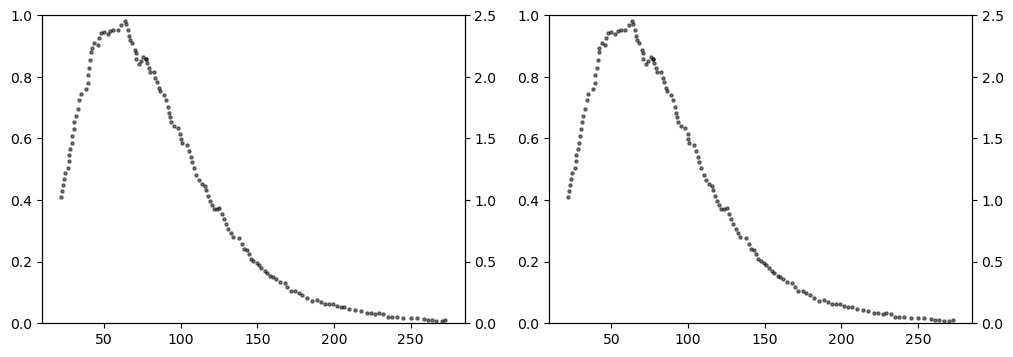

In [3]:
fig,ax = plt.subplots(1,2, figsize = (12,4))

directory_dict = categorizing_pickle('pickle_jar/cavity-292.0_256_292292-boltzmann_0_0-c_Lxy-microz', '')

for i in range(2):
    tax = ax[i].twinx()
    exp_data = pd.read_csv('data/plot-data.csv')
    tax.scatter(
        exp_data.loc[:,'x'],
        exp_data.loc[:,' y'],
        s = 5, alpha = 0.5, c = 'black', 
        label = 'Exp. @ 292K' if i == 0 else None
    )
    tax.set_ylim(-0.00,2.5)

rad_profile = []
rad_profile1 = []
for _, (j, path) in enumerate(directory_dict.items()):
    
    with open(path, 'rb') as handle:
        freefield_result_dict = pickle.load(handle)

    #print(j, np.sum(freefield_result_dict['field'].history['energy'][-1]))

    omega_profile, r = spectra_utils.field_spectra(
        freefield_result_dict, 
        convert_function = {
            'energy': red.convert_energy, 
            'wavenumber':red.convert_wavenumber},
        mode = 'std'
    ) 
    rad_profile.append(r)
    
    omega_profile, r1 = spectra_utils.field_spectra(
        freefield_result_dict, 
        convert_function = {
            'energy': red.convert_energy, 
            'wavenumber':red.convert_wavenumber},
        mode = 'abs'
    ) 
    rad_profile1.append(r1)

    del freefield_result_dict

rad_profile = np.mean(rad_profile, axis = 0)
rad_profile *= 1e3
o, f = moving_average(omega_profile, rad_profile, w = 10)
ax[0].plot(o, f, label = "std")

#ax[0].set_ylim(0.05,0.43)

rad_profile1 = np.mean(rad_profile1, axis = 0)
rad_profile1 *= 1e3
o, f = moving_average(omega_profile, rad_profile1, w = 10)
ax[1].plot(o, f, label = "abs")


In [5]:
len(omega_profile)

259

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


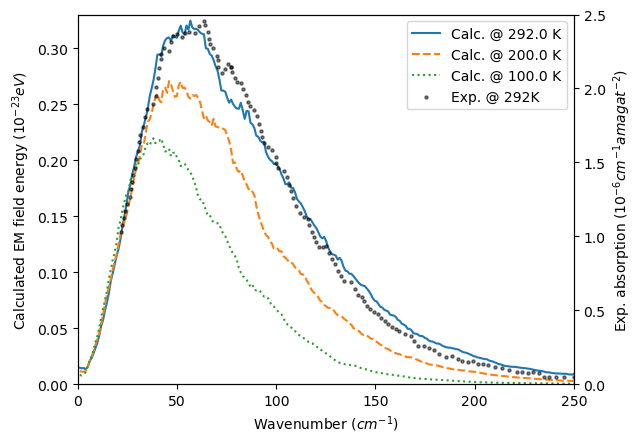

In [3]:
## from copy import deepcopy

fig,ax = plt.subplots()

# plotting the experimental dataset
tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black', 
    label = 'Exp. @ 292K' if i == 0 else None
)
tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')
tax.set_ylim(-0.00,2.5)

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_256_DICT.items()):

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        del freefield_result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e23
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    ax.plot(o, f, label = "Calc. @ {} K".format(temp), linestyle = linestyle_list[i])

    if temp == '100.0':
        rad_profile100 = f
        omega_profile100 = o

ax.scatter([], [], s = 5, alpha = 0.5, c = 'black', label = 'Exp. @ 292K')     
ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax.set_xlim(0,250)
ax.set_ylim(0.0, 0.33)
ax.set_ylabel(r"Calculated EM field energy $(10^{-23} eV)$")
ax.set_xlabel(r"Wavenumber $(cm^{-1})$")

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

In [ ]:
for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_768b_DICT.items()):
    print(temp)

    directory_dict = categorizing_pickle(cavityfield_result_path, '')
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        field = result_dict['field']
        
        print(j, np.sum(field.history['energy'][-1]))

pickle_jar/cavity-100.0_512_512100110-zero_0_0-c_Lxy1e1-microz/result_16.pkl


/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1153

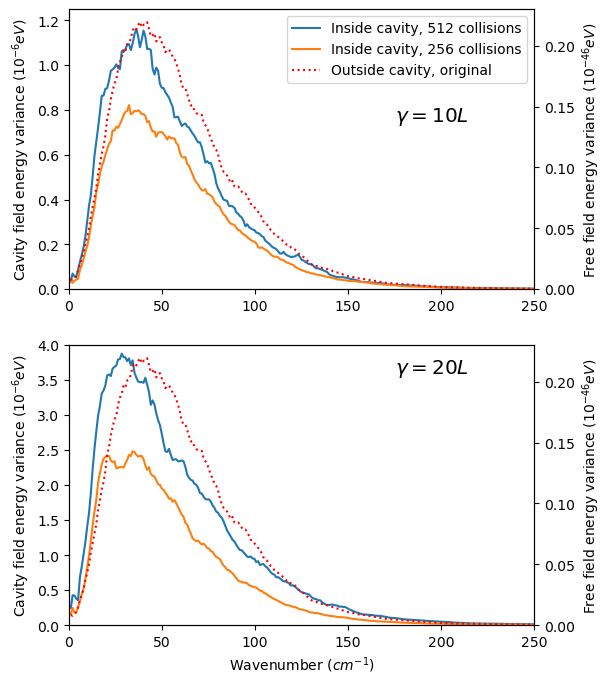

In [4]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768z_DICT,
    '512':CAVITYFIELD_RESULT_512z_DICT, 
    '256':CAVITYFIELD_RESULT_256z_DICT, 
}
limit = {'256':40, '512':20, '768':15}
colors = ['r', 'b']

fig,ax = plt.subplots(2, figsize = (6,8))
max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)
    
            del result_dict
            
            n_pickle += 1
            if n_pickle > limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        ax[i].plot(o, f, label = 'Inside cavity, {} collisions'.format(no_collision))
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})

        ### tabe here ###
        ax[i].set_xlim(0, 250)
        
        tax = ax[i].twinx()
        tax.plot(
            omega_profile100, rad_profile100 * (np.max(rad_profile)/ max_r[i]), 
            linestyle = linestyle_list[2], c = colors[f_]
        )
        tax.set_xlim(0, 250)
        tax.set_ylim(0, 0.23)
    
        ax[i].set_ylabel(r"Cavity field energy variance ($10^{-6} eV$)")
        tax.set_ylabel(r"Free field energy variance ($10^{-46} eV$)")

ax[0].plot(
    [], [], label = "Outside cavity, original" , 
    linestyle = linestyle_list[2],color=colors[0]
)
#"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
#"""

ax[0].set_ylim(0, 1.25)
ax[1].set_ylim(0, 4.0)

ax[1].set_xlabel(r'Wavenumber ($cm^{-1}$)')

ax[0].annotate(r'$\gamma = 10L$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 20L$',xy = (0.7,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()

fig.savefig(fig_root + "cavity_spectrum_.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


14097

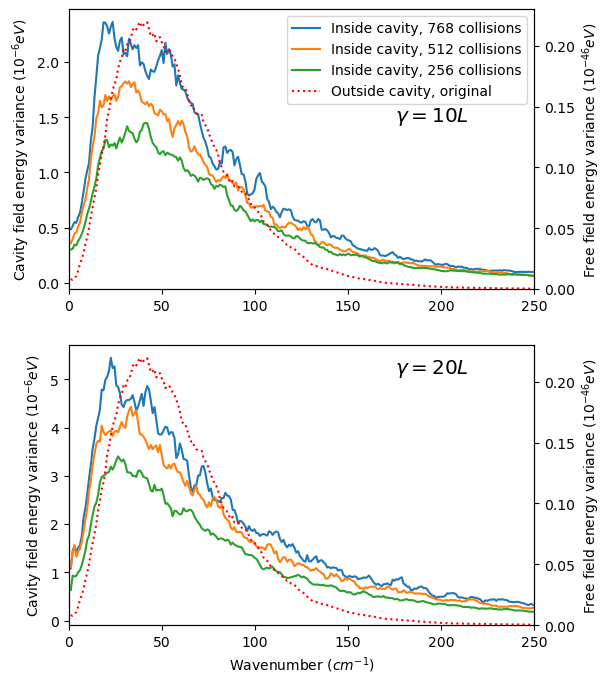

In [6]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    '768':CAVITYFIELD_RESULT_768b_DICT,
    '512':CAVITYFIELD_RESULT_512b_DICT, 
    '256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':20, '768':15}
colors = ['r', 'b', 'g']

fig,ax = plt.subplots(2, figsize = (6,8))
max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)
    
            del result_dict
            
            n_pickle += 1
            if n_pickle > limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 6)
        ax[i].plot(o, f, label = 'Inside cavity, {} collisions'.format(no_collision))
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})
            
            #### tab here ###
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100, rad_profile100 * (np.max(rad_profile)/ max_r[i]), 
                linestyle = linestyle_list[2], c = colors[f_]
            )
            tax.set_xlim(0, 250)
            tax.set_ylim(0, 0.23)
        
            ax[i].set_ylabel(r"Cavity field energy variance ($10^{-6} eV$)")
            tax.set_ylabel(r"Free field energy variance ($10^{-46} eV$)")
            
        ax[i].set_xlim(0, 250)
        

ax[0].plot(
    [], [], label = "Outside cavity, original" , 
    linestyle = linestyle_list[2],color=colors[0]
)
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)

ax[1].set_xlabel(r'Wavenumber ($cm^{-1}$)')

ax[0].annotate(r'$\gamma = 10L$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 20L$',xy = (0.7,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()

fig.savefig(fig_root + "boltzmann_cavity_spectrum_.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(2,2, figsize = (10,8))

foo = [CAVITYFIELD_RESULT_256z_DICT, CAVITYFIELD_RESULT_512z_DICT]

letters = ['a', 'b', 'c']

ct_dict = {}

for j, result_dict in enumerate(foo):
    food = {}
    for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
        
        cavityfield_result_dict = result_dict[coup_str]
        ct = getall_colliding_time(cavityfield_result_dict, limit = 40)
        ct = np.array(ct, dtype = np.float32)
    
        frame = np.arange(5.9999, 214.9999, 4.9999, dtype = np.float32)
        bin2 = ax[i,j].hist(ct, frame)
    
        food.update({coup_str : ct})
        
        del ct
        del cavityfield_result_dict
    
        ax[i,j].yaxis.set_major_formatter('{x:.0f}')
        
        ax[i,j].xaxis.set_major_locator(MultipleLocator(25))
        ax[i,j].set_xticks(list(ax[i,j].get_xticks()) + [6])
        ax[i,j].set_xlim(6,215)
        
        
        if i == 0:
            ax[i,j].set_ylim(0,30)
            ax[i,j].yaxis.set_major_locator(MultipleLocator(10))
            
        elif i == 1:
            ax[i,j].set_ylim(0,175)
            ax[i,j].yaxis.set_major_locator(MultipleLocator(25))

        ax[i,j].annotate(
            '({}-{})'.format(letters[i], j + 1), 
            xy = (0.5,0.9), xycoords = 'axes fraction',
            size = 'x-large', )
    ct_dict.update({j: food})

ax[1,0].set_xlabel('Colliding time (ps)')
ax[1,1].set_xlabel('Colliding time (ps)')
#ax[1,2].set_xlabel('Colliding time (ps)')

ax[0,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')
ax[1,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[0,0].annotate(r'cavity, 256 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,1].annotate(r'cavity, 512 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate(r'cavity, 256 atom pairs, $\gamma = 20L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate(r'cavity, 512 atom pairs, $\gamma = 20L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

fig.savefig(fig_root + 'histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
for i, foo in ct_dict.items():
    for coup_str, ct in foo.items():
        print(i, coup_str,len(ct[ct > 6]),  np.mean(ct[ct > 6]), len(ct[ct > 200]), len(ct))

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(3,2, figsize = (10,12))

bin_dict = {}

ct0 = getall_colliding_time(FREEFIELD_RESULT_256_DICT['100.0'], limit = 0)

bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
    i+= 1
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = 40)

    bin1 = ax[i,0].hist(ct, np.arange(0,6 + 0.1, 0.1))
    bin2 = ax[i,1].hist(ct, np.arange(5.9999,214.9999,4.9999))
    
    bin_dict.update({coup_str: (bin1, bin2)})

    ct_dict2.update({coup_str : ct})
    
    del ct
    del cavityfield_result_dict
        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')

    if i == 0:  
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
    elif i == 1:
        ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(3):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [6])
    ax[i,1].set_xlim(6,215)
    ax[i,0].set_xlim(0,6)
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[2,0].set_xlabel('Colliding time (ps)')
ax[2,1].set_xlabel('Colliding time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,0].annotate('free space',xy = (0.65,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate(r'cavity, $\gamma = 10L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,0].annotate('(c-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,0].annotate(r'cavity, $\gamma = 20L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,1].annotate('free space',xy = (0.65,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate(r'cavity, $\gamma = 10L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,1].annotate('(c-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,1].annotate(r'cavity, $\gamma = 20L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

fig.savefig(fig_root + 'histogram_boltzmann_512.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
# 256
for coup_str, ct in ct_dict2.items():
        print(i, coup_str,len(ct[ct > 6]),  np.mean(ct[ct > 6]), len(ct[ct > 200]), len(ct))

In [ ]:
# 512
for coup_str, ct in ct_dict2.items():
    print(i, coup_str,len(ct[ct > 6]),  np.mean(ct[ct > 6]), len(ct[ct > 200]), len(ct))

In [ ]:
cavityfield_result_dict2 = categorizing_pickle(
    CAVITYFIELD_RESULT_DICT2['Lxy15'], ''
)
with open(cavityfield_result_dict2[1],'rb') as handle:
    cavityfield_result_dict2 = pickle.load(handle)

In [ ]:
atoms = cavityfield_result_dict2['atoms']
coltime = np.array(get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = cavityfield_result_dict2['field']
atoms = cavityfield_result_dict2['atoms']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

In [ ]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
wn_list = red.convert_wavenumber(field.k_val)

In [ ]:
fig,ax = plt.subplots(3,figsize = (8,12))

hem = np.array(field.history['energy'])

t0 = 190; tf = 205
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[0].plot(x, y)
ax[0].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 250; tf = 275
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[1].plot(x,y)
ax[1].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 230; tf = 240
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[2].plot(x,y)
ax[2].vlines(22.766, min(y), max(y), linestyle = 'dotted')


In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = i , N_pairs = N_pairs, save_path = 'figure2/longest_anime')

In [ ]:
for i, (temp, result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):

    if i == 0: continue
    result_dict = categorizing_result(result_path)

    for j in result_dict.keys():
        atoms = result_dict[j]['atoms']
        field = result_dict[j]['field']
    
        k = np.array(atoms.observable['kinetic'])
        v = np.array(atoms.observable['potential'])
        
        hrad = np.sum(field.history['energy'], axis = 1)
        t = field.history['t']
        
        total = k + v + hrad
        print(red.convert_energy(
            (total[0] - total[-1]) / (512*3 + 300 * 2)
            ,'ev'
        ))

In [ ]:
red.convert_energy(1 / (512 * 3 + 300) , 'ev')

In [ ]:
fig,ax = plt.subplots(3, figsize = (6,12))

foo = [5,12,14]

for i, (cs, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    cavityfield_result_dict = categorizing_result(CAVITYFIELD_RESULT_DICT2[cs], '')
    
    wn, spec1 = dipole_spectra(cavityfield_result_dict, 1e-2,time_frame = (5.0, np.inf), windows = 'Gaussian')
    
    #w, s = pt.moving_average(wn_real, spec1, w = 2)
    spec1 = np.mean(spec1, axis = 0)
    spec1 = spec1[wn < 75] * 1e6
    wn = wn[wn < 75]
    ax[i].plot(wn, spec1, label = "T = {} K".format(temp))
    ax[i].vlines(vib_freq, min(spec1), max(spec1), linestyle = 'dotted')
    
    del cavityfield_result_dict

ax[0].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_ylabel("Emission (Arbitrary unit)")
ax[2].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_xlabel("Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "cavity_spectrum_peak.jpeg",dpi = 600,bbox_inches = 'tight')